# Single-label plots

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from plantclef.utils import get_spark

spark = get_spark()
display(spark)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/06/23 15:28:43 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
24/06/23 15:28:44 WARN SparkConf: Note that spark.local.dir will be overridden by the value set by the cluster manager (via SPARK_LOCAL_DIRS in mesos/standalone/kubernetes and LOCAL_DIRS in YARN).


In [6]:
# get dataframes
gcs_path = "gs://dsgt-clef-plantclef-2024"
data_path = "data/parquet_files/PlantCLEF2024_training_cropped_resized_v2"

# paths to dataframe
train_path = f"{gcs_path}/{data_path}"
# read data
train_df = spark.read.parquet(train_path)
# show
train_df.show(n=10, truncate=50)

+--------------------------------------------+--------------------------------------------------+------+----------+----------+----------------------------------------------+-------+-------------------------------------+--------+-----------------+------------------+---------------+--------------------------------------------------+-----------+-------------+--------+-----------+--------------------------------------------------+--------------------------------------------------+---------+--------------------------------------------------+--------------------------------------------------+
|                                  image_name|                                              path| organ|species_id|    obs_id|                                       license|partner|                               author|altitude|         latitude|         longitude|gbif_species_id|                                           species|      genus|       family| dataset|  publisher|                           

In [4]:
import os
import io
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from pathlib import Path
from pyspark.sql import DataFrame
from pyspark.sql import functions as F

In [10]:
# Path and dataset names
gcs_path = "gs://dsgt-clef-plantclef-2024/data/parquet_files/"
original_images = "PlantCLEF2024_training"

# Define the GCS path to the Train parquet file
original_gcs_path = f"{gcs_path}{original_images}"

# Read the Parquet file into a DataFrame
original_df = spark.read.parquet(original_gcs_path)

In [11]:
original_df.show(n=10, truncate=50)

+--------------------------------------------+--------------------------------------------------+--------------------------------------------------+------+----------+----------+--------+-------+----------------------------+--------+-----------------+------------------+---------------+--------------------------------------------------+-----------+-------------+--------+---------+--------------------------------------------------+--------------------------------------------------+---------+--------------------------------------------------+
|                                  image_name|                                              path|                                              data| organ|species_id|    obs_id| license|partner|                      author|altitude|         latitude|         longitude|gbif_species_id|                                           species|      genus|       family| dataset|publisher|                                        references|                       

In [12]:
# select image names
image_names = [
    "500bcfc34cf1099de26c124c319d8128d75158c1.jpg",
    "99f953c12b5c3434315e0b7374174bbda8d103d4.jpg",
    "be0867f3cc1b1af711895ea5543ffcb9c59a3c87.jpg",
]

In [25]:
# filter for 3 images
subset_df = (
    train_df.select("image_name", "data")
    .where(F.col("image_name").isin(image_names))
    .cache()
)
subset_df.show()

Exception in thread "serve-DataFrame" java.net.SocketTimeoutException: Accept timed out
	at java.base/java.net.PlainSocketImpl.socketAccept(Native Method)
	at java.base/java.net.AbstractPlainSocketImpl.accept(AbstractPlainSocketImpl.java:474)
	at java.base/java.net.ServerSocket.implAccept(ServerSocket.java:565)
	at java.base/java.net.ServerSocket.accept(ServerSocket.java:533)
	at org.apache.spark.security.SocketAuthServer$$anon$1.run(SocketAuthServer.scala:65)


+--------------------+--------------------+
|          image_name|                data|
+--------------------+--------------------+
|500bcfc34cf1099de...|[FF D8 FF E0 00 1...|
|99f953c12b5c34343...|[FF D8 FF E0 00 1...|
|be0867f3cc1b1af71...|[FF D8 FF E0 00 1...|
+--------------------+--------------------+



In [23]:
def plot_single_label_images(df, image_name: str, image_num: int):
    image_row = df.where(F.col("image_name") == image_name).collect()
    image_binary = image_row[0]["data"]
    # Convert the binary data to an image using PIL
    image = Image.open(io.BytesIO(image_binary))
    # Display the image using Matplotlib
    fig, ax = plt.subplots(dpi=300)
    ax.imshow(image)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.axis("off")
    plt.tight_layout()
    plt.subplots_adjust(top=0.90)
    path = Path(os.getcwd()).parents[1]
    plt.savefig(
        f"{path}/figures/single-label-image{image_num+1}.png", bbox_inches="tight"
    )
    plt.show()

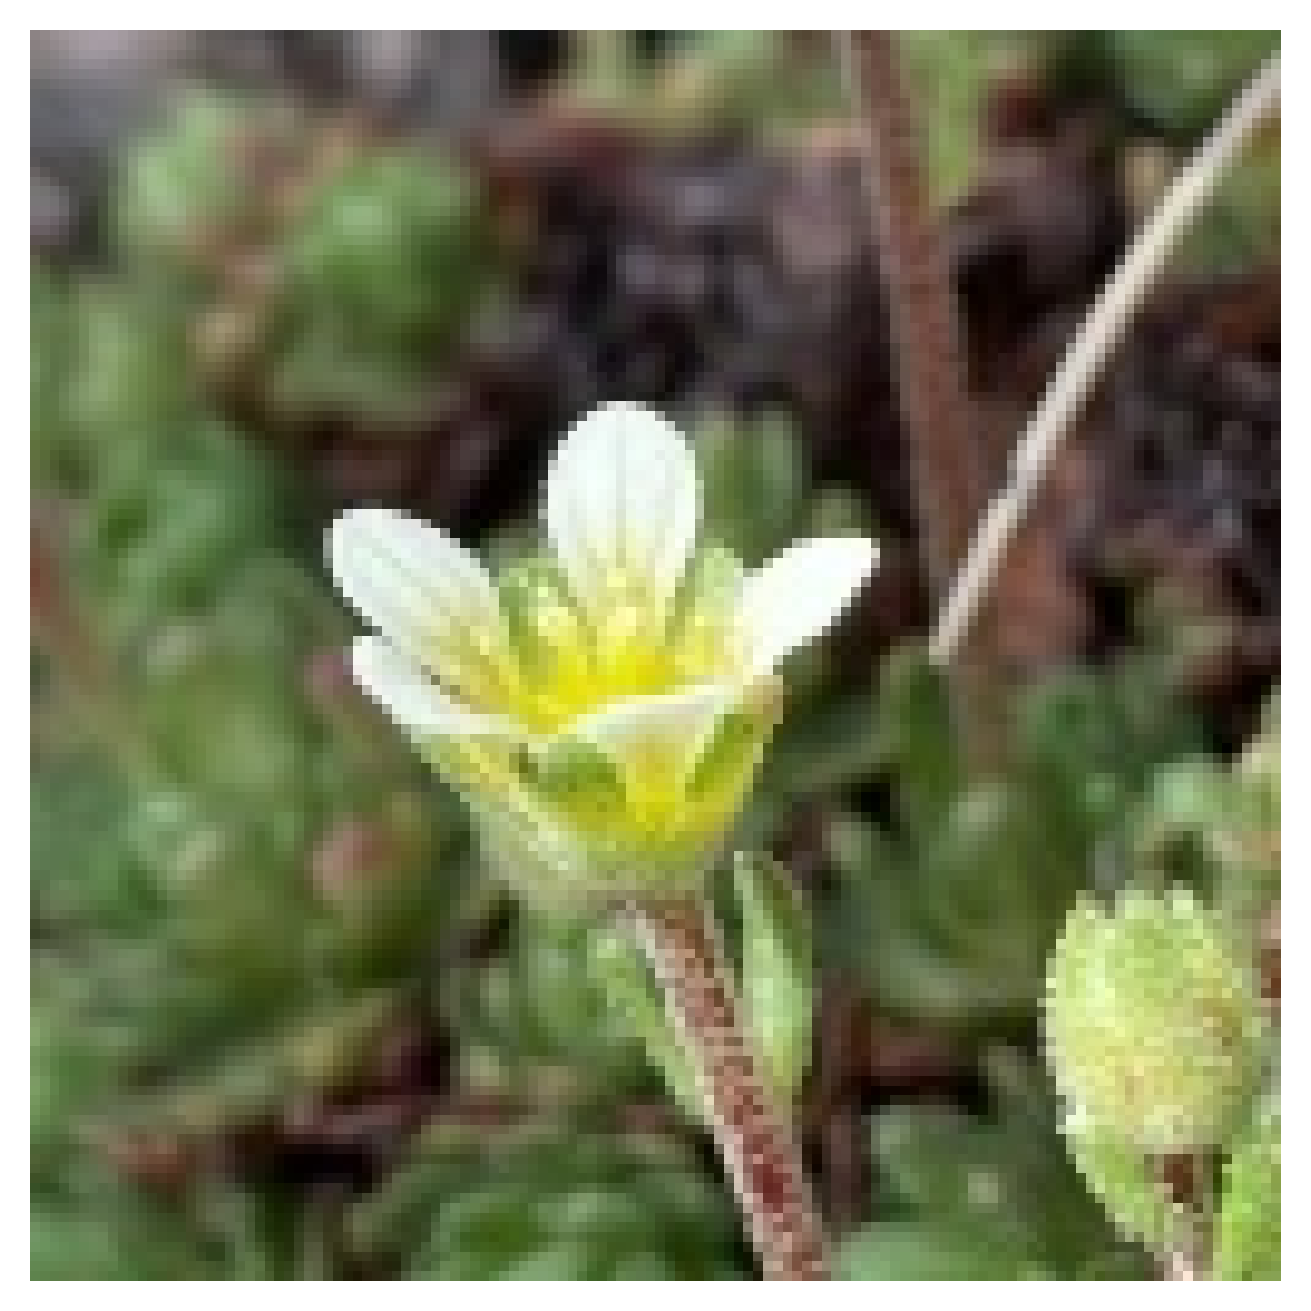

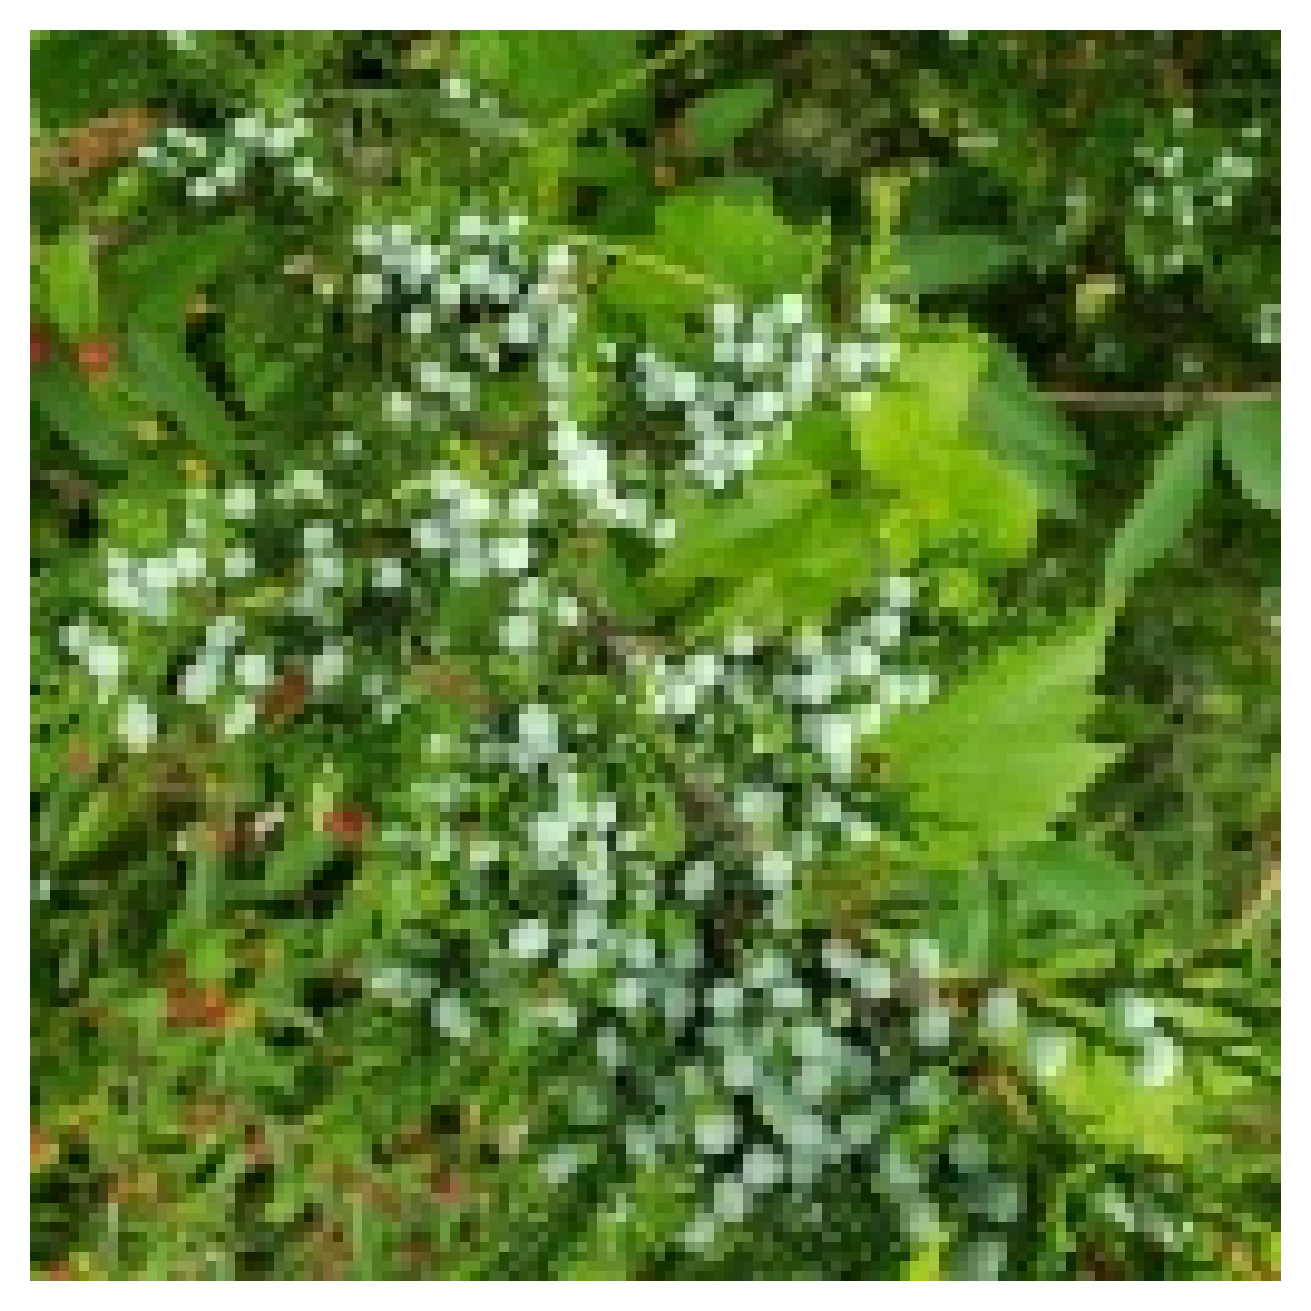

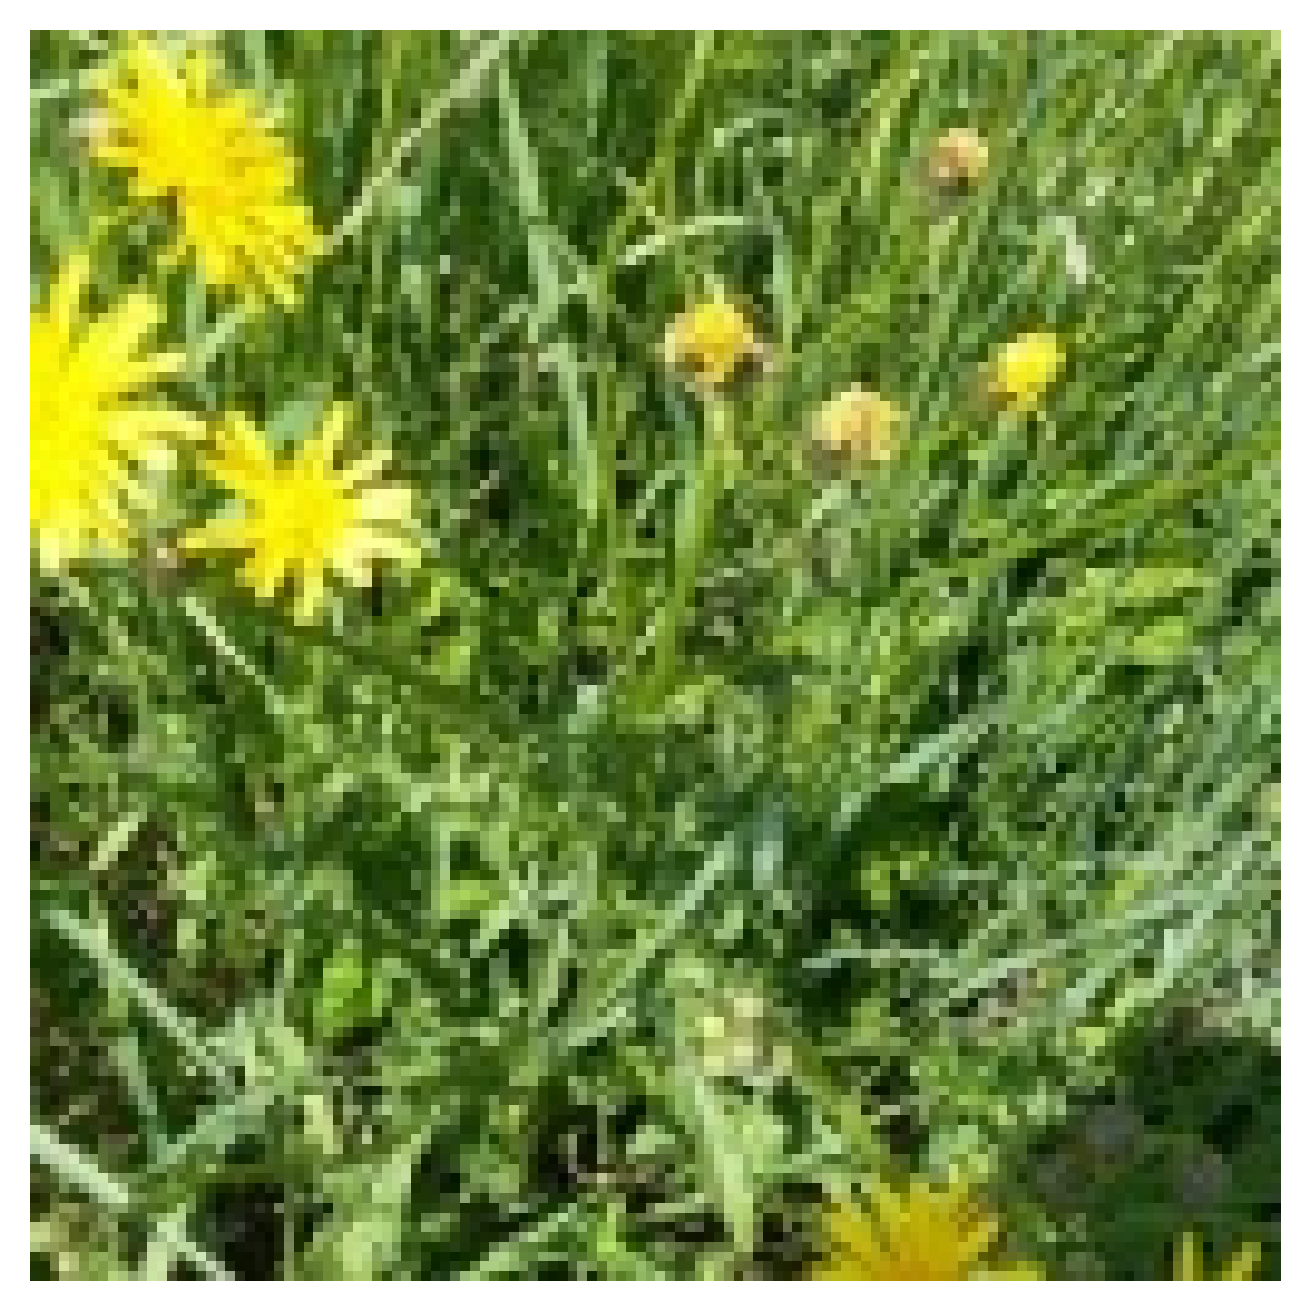

In [26]:
for i, image_name in enumerate(image_names):
    plot_single_label_images(subset_df, image_name, image_num=i)

### embeddings

In [29]:
# Path and dataset names
gcs_path = "gs://dsgt-clef-plantclef-2024/data/process/training_cropped_resized_v2"
dct_path = "dino_dct/data"
cls_path = "dino_cls_token/data"

# Define the GCS path to the Train parquet file
dct_gcs_path = f"{gcs_path}/{dct_path}"
cls_gcs_path = f"{gcs_path}/{cls_path}"

# Read the Parquet file into a DataFrame
dct_df = spark.read.parquet(dct_gcs_path)
cls_df = spark.read.parquet(cls_gcs_path)

# show
dct_df.show(n=5)
cls_df.show(n=5)

+--------------------+----------+--------------------+
|          image_name|species_id|       dct_embedding|
+--------------------+----------+--------------------+
|170e88ca9af457daa...|   1742956|[-20648.51, 2133....|
|c24a2d8646f5bc711...|   1356834|[-25395.82, -1256...|
|e1f68e5f056189219...|   1563754|[-26178.633, -767...|
|b0433cd6968b57d52...|   1367432|[-23662.764, -677...|
|96478a0fe20a41e75...|   1389010|[-22182.172, -194...|
+--------------------+----------+--------------------+
only showing top 5 rows

+--------------------+----------+--------------------+
|          image_name|species_id|       cls_embedding|
+--------------------+----------+--------------------+
|5ddad155a99ff9b22...|   1390691|[1.2776474, 1.459...|
|ea74d65858ceb7d55...|   1360260|[-1.9118708, 3.05...|
|86eb8b2e1a7b6a6d4...|   1390699|[0.57074785, 1.79...|
|4dd8c6a10041b1c02...|   1396486|[0.85863805, -2.9...|
|1d5d139f575031bd1...|   1356608|[-0.4914153, -1.3...|
+--------------------+----------+-------

In [30]:
# subset of dataframes
dct_sub_df = dct_df.where(F.col("image_name").isin(image_names)).cache()
cls_sub_df = cls_df.where(F.col("image_name").isin(image_names)).cache()

In [35]:
import math


def plot_emb_full_image(
    df,
    image_name: str,
    data_col: str,
    image_num: int,
    algo_name: str,
):
    image_row = df.where(F.col("image_name") == image_name).collect()
    embedding = image_row[0][data_col]

    # Find the next perfect square size greater than or equal to the embedding length
    next_square = math.ceil(math.sqrt(len(embedding))) ** 2
    padding_size = next_square - len(embedding)

    # Pad the embedding if necessary
    if padding_size > 0:
        embedding = np.pad(embedding, (0, padding_size), "constant", constant_values=0)

    # Reshape the embedding to a square
    side_length = int(math.sqrt(len(embedding)))
    image_array = np.reshape(embedding, (side_length, side_length))

    # Normalize the embedding to [0, 255] for displaying as an image
    normalized_image = (
        (image_array - np.min(image_array))
        / (np.max(image_array) - np.min(image_array))
        * 255
    )
    image = Image.fromarray(normalized_image).convert("L")

    # Display the image using Matplotlib
    fig, ax = plt.subplots(dpi=300)
    ax.imshow(image, cmap="gray")
    ax.set_xticks([])
    ax.set_yticks([])
    ax.axis("off")
    plt.tight_layout()
    plt.subplots_adjust(top=0.90)
    path = Path(os.getcwd()).parents[1]
    plt.savefig(
        f"{path}/figures/single_label-{algo_name}-emb{image_num+1}.png",
        bbox_inches="tight",
    )
    plt.show()

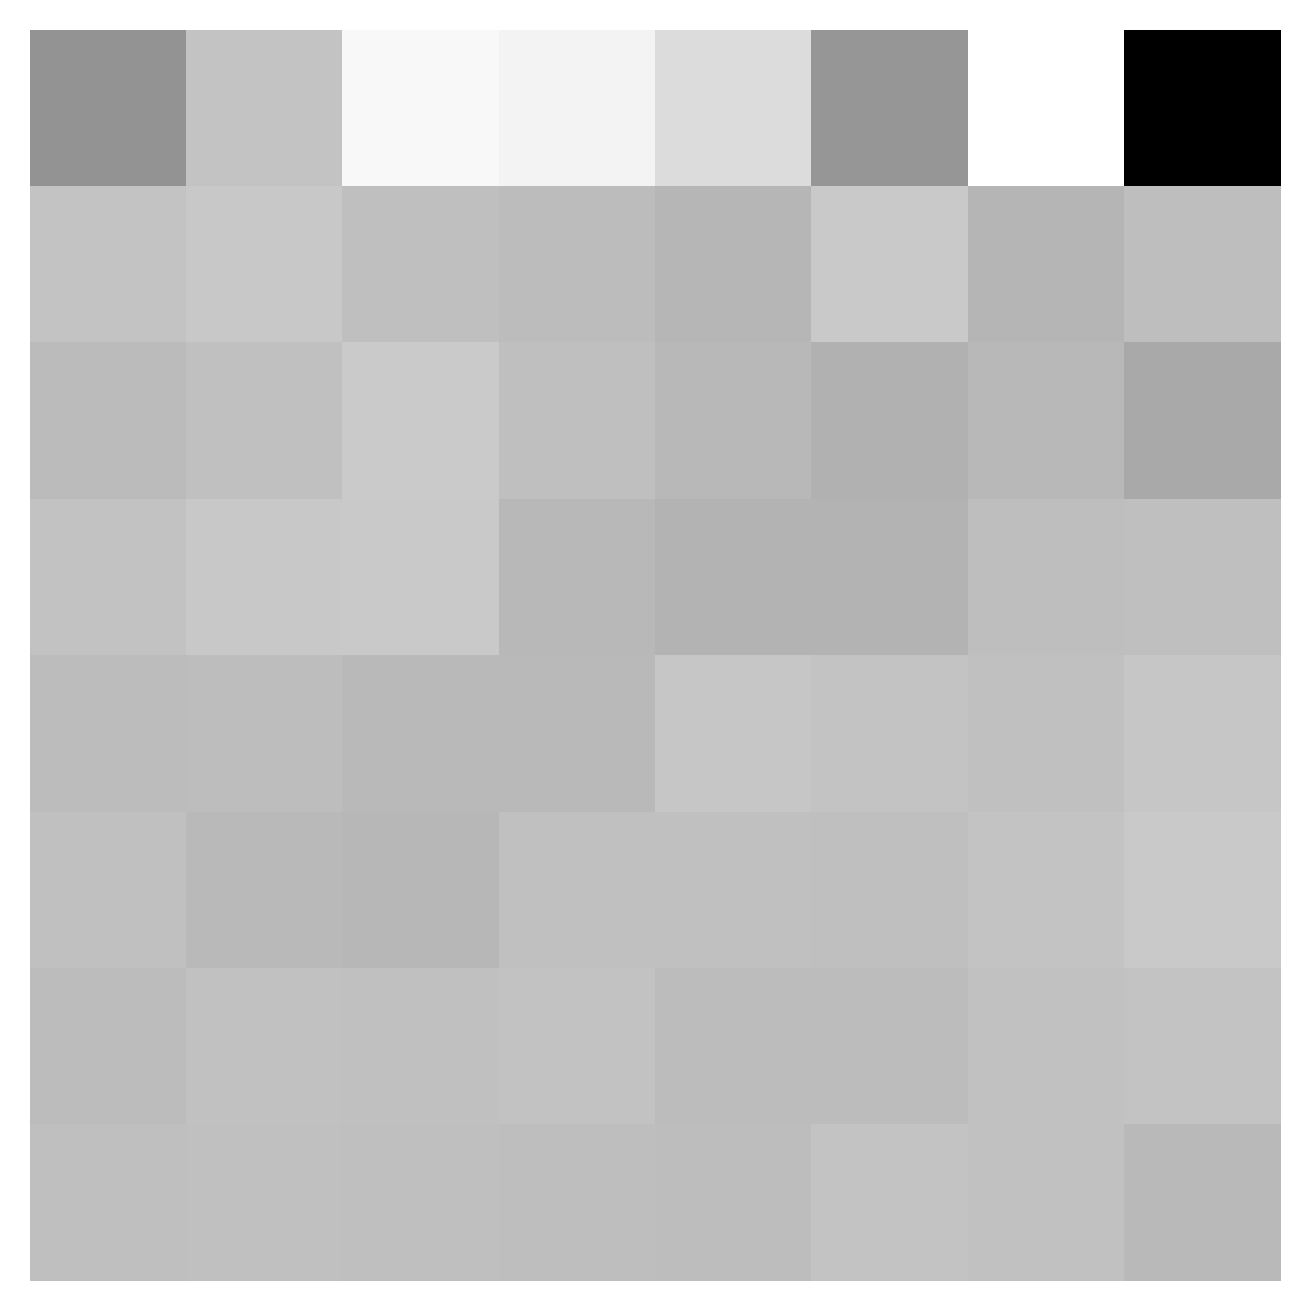

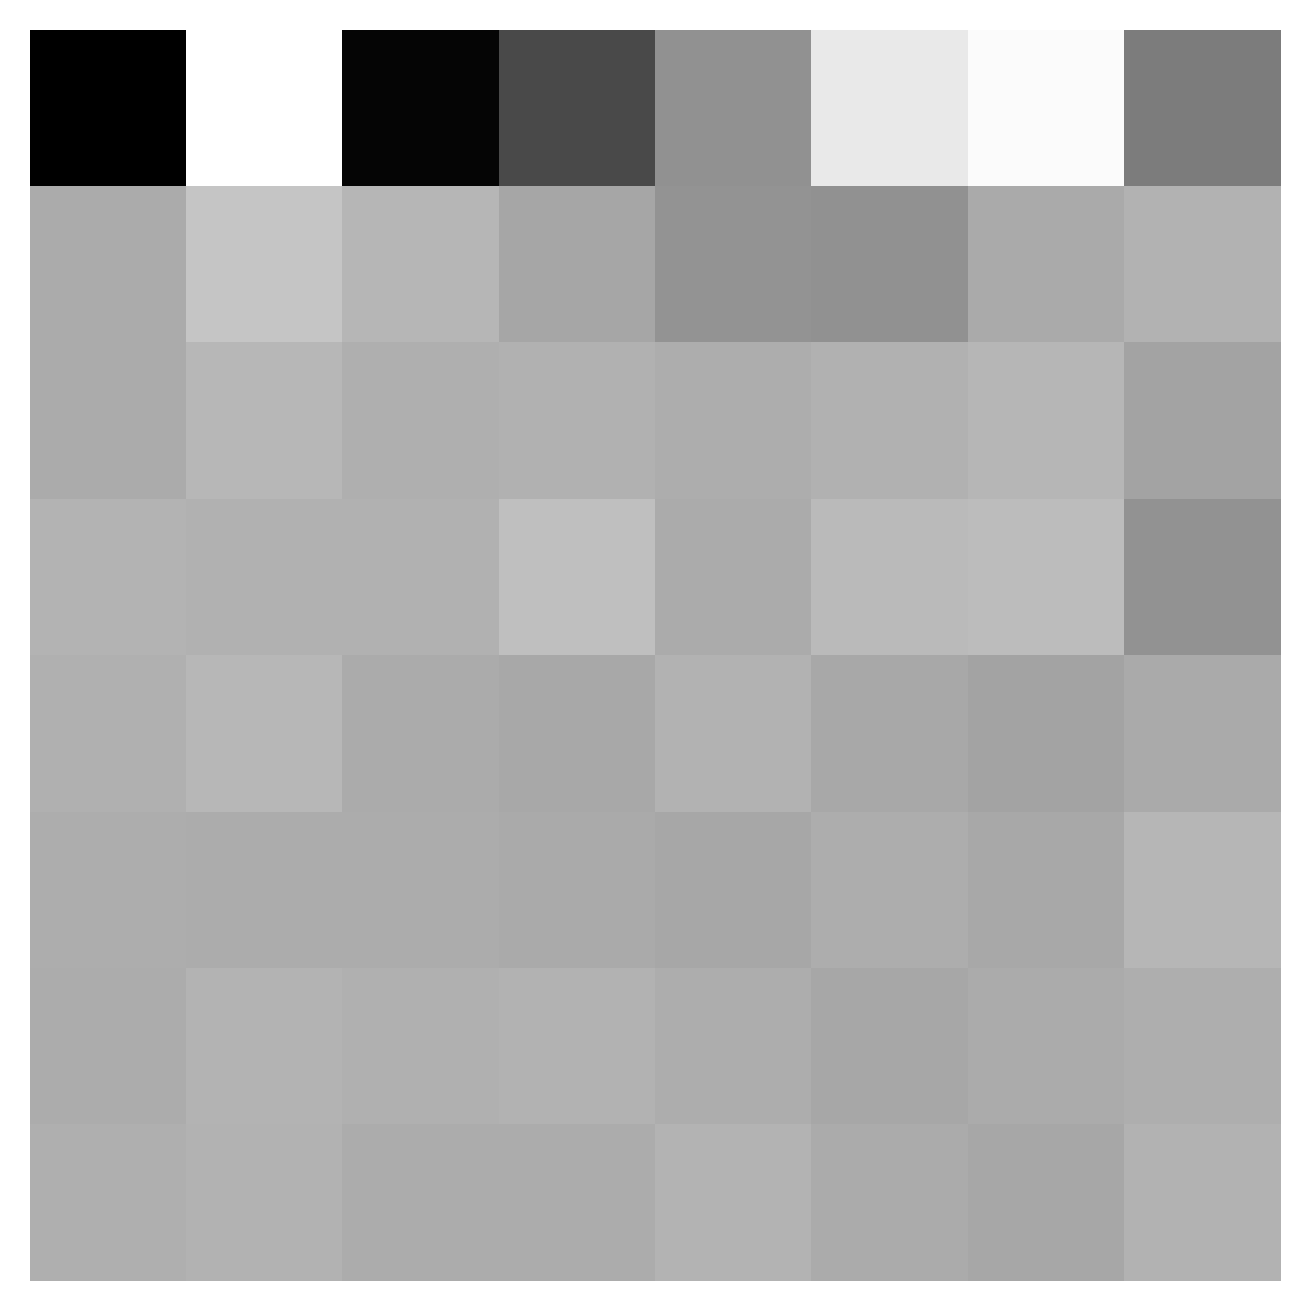

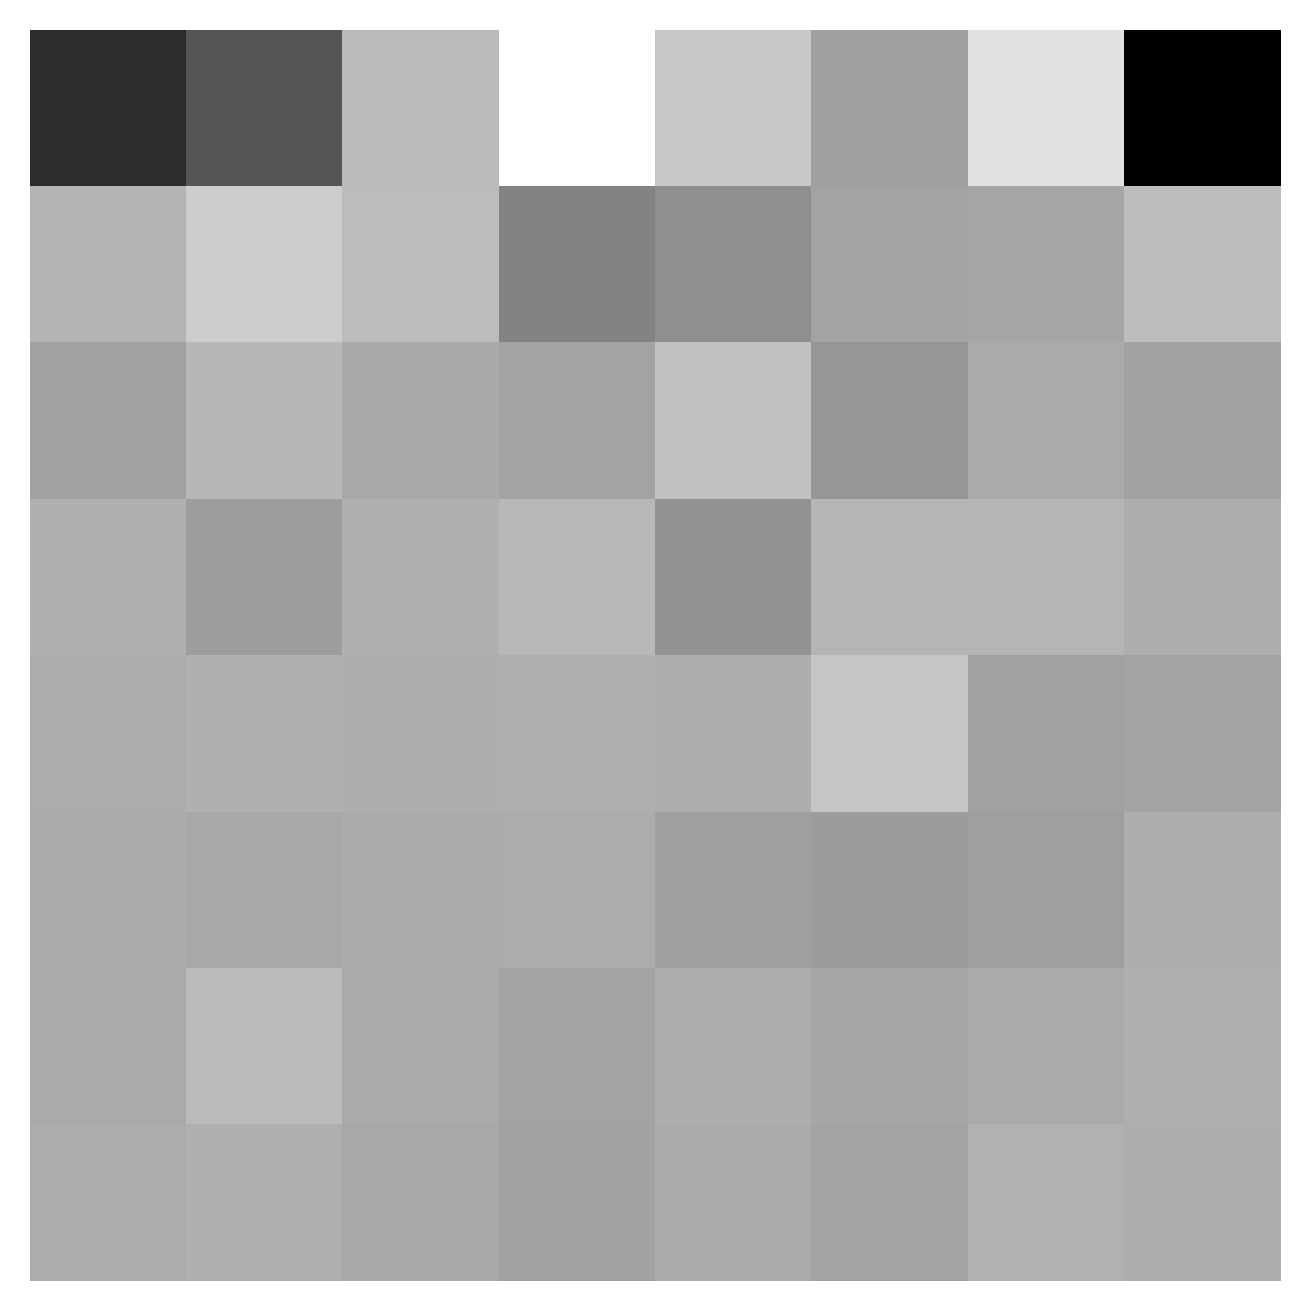

In [36]:
# DCT embedding single-label plot
for i, image_name in enumerate(image_names):
    plot_emb_full_image(
        dct_sub_df, image_name, "dct_embedding", image_num=i, algo_name="DCT"
    )

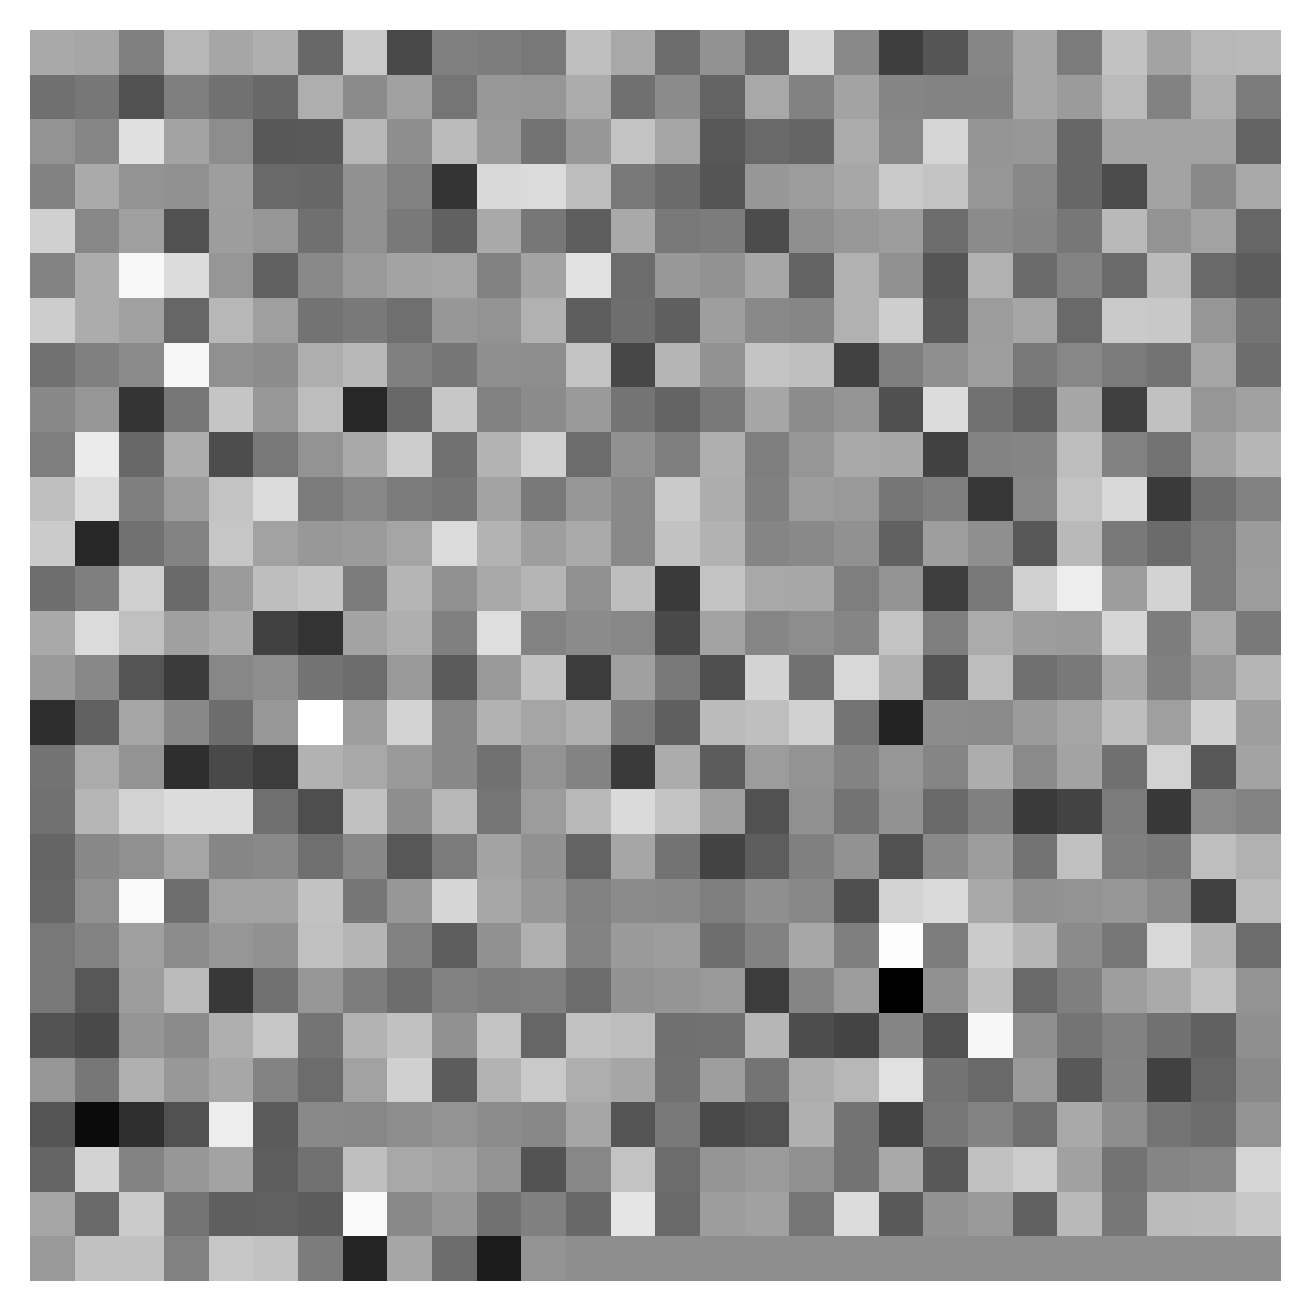

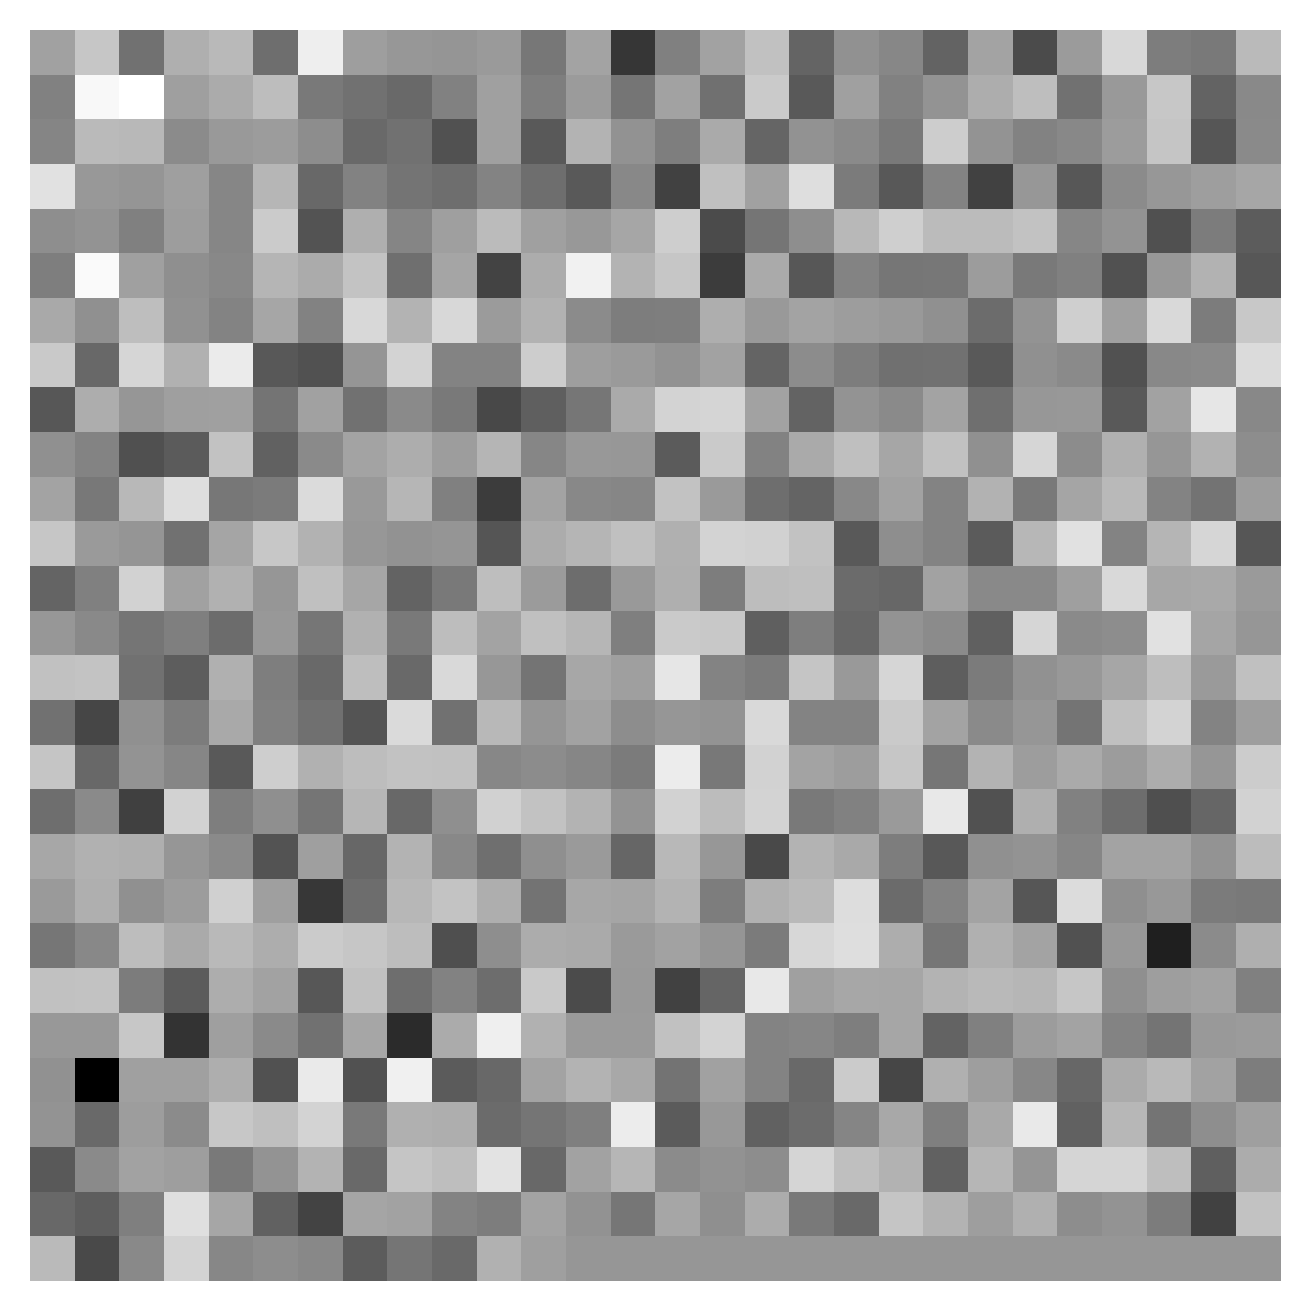

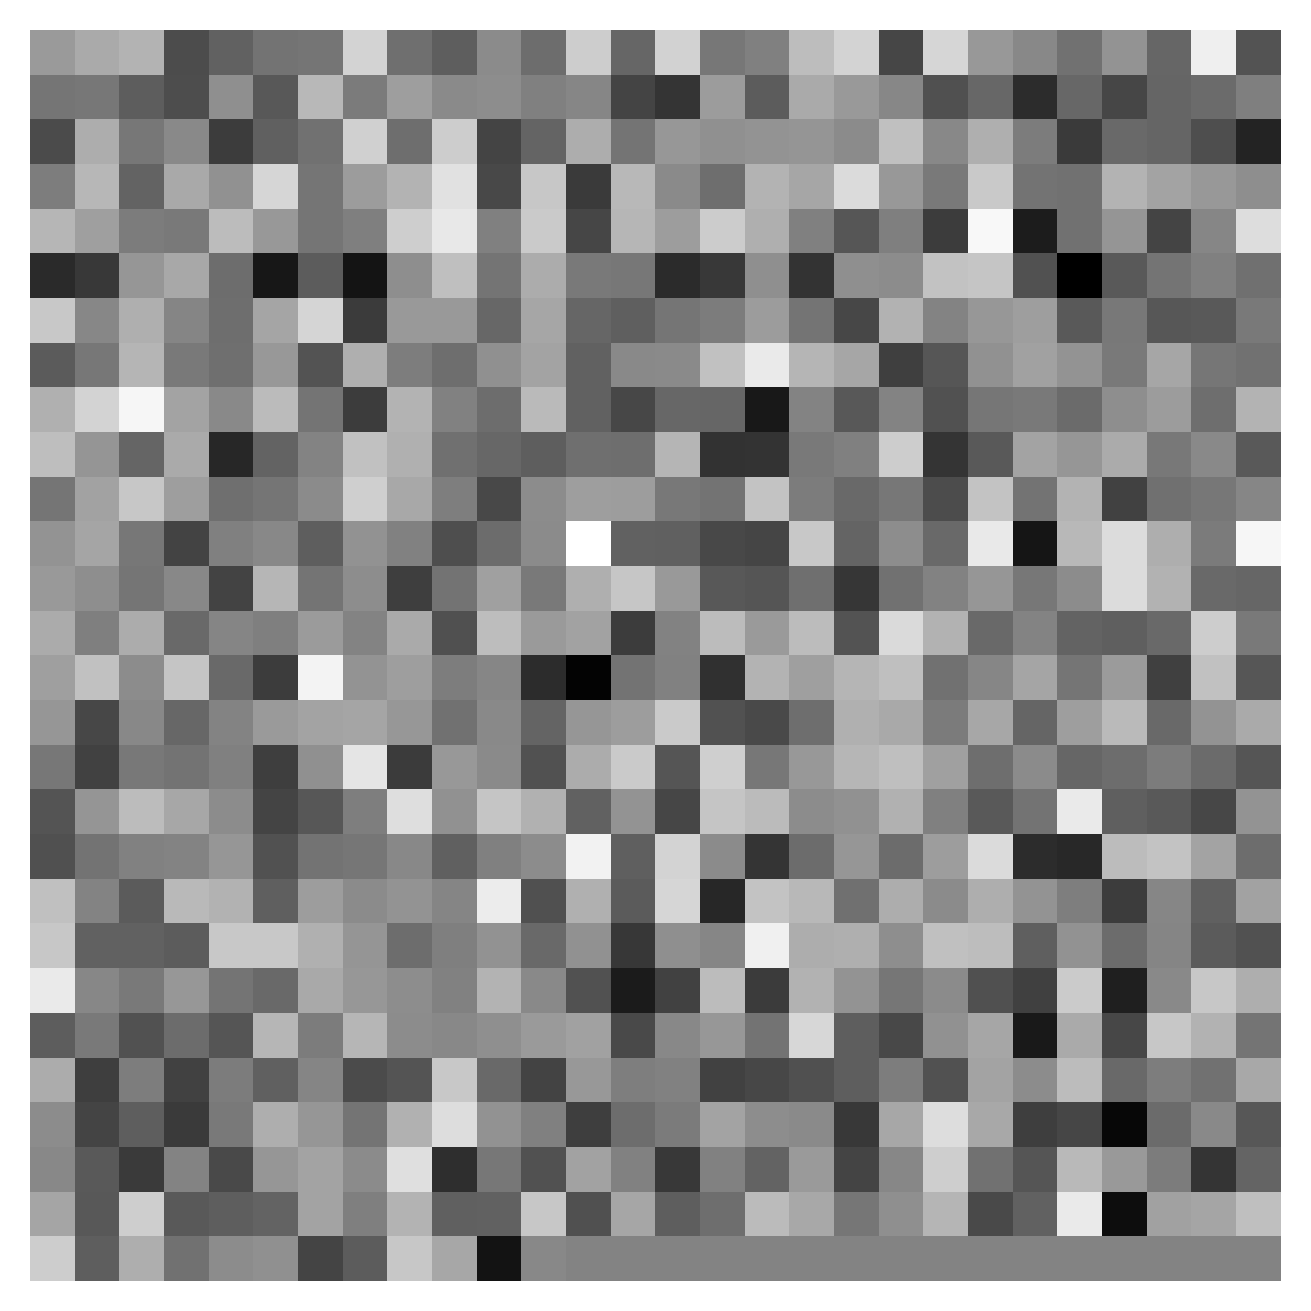

In [37]:
# DCT embedding single-label plot
for i, image_name in enumerate(image_names):
    plot_emb_full_image(
        cls_sub_df, image_name, "cls_embedding", image_num=i, algo_name="CLS"
    )